In [2]:
import numpy as np
import json
import tensorflow as tf
import torch
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from itertools import combinations 
import matplotlib.transforms
import collections
import re

# Attention analysis

## Extracting attention from different models

### Loading the models

In [3]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer, AutoModelForMaskedLM

In [4]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model_name = "DeepPavlov/bert-base-cased-conversational"
bert_conversational_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_conversational_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at DeepPavlov/bert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model_name = "Elron/bleurt-base-128"
bleurt_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
bleurt_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
model_name = "./bert/gpt2-pretrained-on-dailydialog"
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)
#gpt2_tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2_tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

In [8]:
model_name = "microsoft/DialoGPT-medium"  
dialogpt_model = AutoModel.from_pretrained(model_name, output_attentions = True)  
dialogpt_tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/DialoGPT-medium were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
model_name = "TODBERT/TOD-BERT-JNT-V1"
todbert_tokenizer = AutoTokenizer.from_pretrained(model_name)
todbert_model = AutoModelForMaskedLM.from_pretrained(model_name, output_attentions=True)

### Preparing inputs for the models

In [10]:
#dialoghi interi
lst_dict = []
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bleurt_tokenized = bleurt_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        bert_conversational_tokenized = bert_conversational_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bleurt_tokenized) < 513 and len(bert_conversational_tokenized) < 513:
            lst_dict.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "), 
                             'gpt2': l.replace("__eou__", dialogpt_tokenizer.eos_token).replace("\n", ""),
                             'txt': l.replace("\n", "").replace("'", " ' ")})

100%|██████████| 13118/13118 [00:09<00:00, 1440.73it/s]


### Extracting attentions

In [11]:
def from_torch_tensor2_numpy(tensor):
    arr = np.empty((len(tensor), tensor[0].size()[1], tensor[0].size()[-1], tensor[0].size()[-1]))
    for i, item in enumerate(tensor):
        arr[i] = item[0].cpu().detach().numpy()
    return arr

In [108]:
import spacy
from spacy.symbols import ORTH
nlp = spacy.load("en_core_web_sm")
special_case = [{ORTH: "gonna"}]
nlp.tokenizer.add_special_case("gonna", special_case)
special_case = [{ORTH: "gotta"}]
nlp.tokenizer.add_special_case("gotta", special_case)


In [272]:
def from_tkn_to_spacy(dict_txt, tokenizer, model_type):
    txt = dict_txt['txt']
    tkn_spacy, tkn_spacy_aligned = [], ["[CLS]"] if  model_type == 'bert' else []
    head_spacy, head_spacy_aligned = [], [None] if  model_type == 'bert' else []
    word_spacy, word_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    pos_spacy, pos_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    for utt in txt.split("__eou__"):
        doc = nlp(utt)
        for tkn in doc:
            if tkn.text.strip() !="":
                tokenized = tokenizer.convert_ids_to_tokens(tokenizer.encode(tkn.text, return_tensors = 'pt', add_special_tokens = False)[0])
                if len(tokenized) > 1:
                    for _ in tokenized:
                        tkn_spacy_aligned.append(tkn.dep_)
                        head_spacy_aligned.append(tkn.head.i)
                        word_spacy_aligned.append(tkn.text)
                        pos_spacy_aligned.append(tkn.pos_)
                else:
                    tkn_spacy_aligned.append(tkn.dep_)
                    head_spacy_aligned.append(tkn.head.i)
                    word_spacy_aligned.append(tkn.text)
                    pos_spacy_aligned.append(tkn.pos_)
                    tkn_spacy.append(tkn.dep_)
                    head_spacy.append(tkn.head.i)
                    word_spacy.append(tkn.text)
                    pos_spacy.append(tkn.pos_)
        
        tkn_spacy_aligned.append("[SEP]") if model_type == 'bert' else tkn_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        word_spacy_aligned.append("[SEP]") if model_type == 'bert' else word_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        head_spacy_aligned.append("[SEP]") if model_type == 'bert' else head_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        pos_spacy_aligned.append("[SEP]") if model_type == 'bert' else pos_spacy_aligned.append(dialogpt_tokenizer.eos_token)
    
    tkn_spacy = tkn_spacy[:-1] if model_type == 'bert' else tkn_spacy
    tkn_spacy_aligned = tkn_spacy_aligned[:-1] if model_type == 'bert' else tkn_spacy_aligned
    word_spacy_aligned = word_spacy_aligned[:-1] if model_type == 'bert' else word_spacy_aligned
    head_spacy_aligned = head_spacy_aligned[:-1] if model_type == 'bert' else head_spacy_aligned
    pos_spacy_aligned = pos_spacy_aligned[:-1] if model_type == 'bert' else pos_spacy_aligned
    return tkn_spacy, word_spacy, head_spacy, pos_spacy, tkn_spacy_aligned, word_spacy_aligned, head_spacy_aligned, pos_spacy_aligned

In [273]:
models = ['bert', 'tod_bert', 'bleurt', 'bert_conversational']

In [274]:
attention_dicts = {}
keys = [('bert', bert_tokenizer, 'bert', bert_model),         
        #('dialogpt', dialogpt_tokenizer, 'gpt2', dialogpt_model), 
        ('tod_bert', todbert_tokenizer, 'bert', todbert_model),
        ('bleurt', bleurt_tokenizer, 'bert', bleurt_model),
        ('bert_conversational', bert_conversational_tokenizer, 'bert', bert_conversational_model)]
        #('gpt2', gpt2_tokenizer, 'gpt2', gpt2_model)]
        

attention_dicts = {
    k: [] for k in models
}

for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})


100%|██████████| 300/300 [00:25<00:00, 11.78it/s]


In [275]:
attention_dicts['bert'][0]['pos_aligned']

['[CLS]',
 'DET',
 'NOUN',
 'VERB',
 'VERB',
 'PUNCT',
 '[SEP]',
 'PRON',
 'PUNCT',
 'AUX',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 '[SEP]']

### Evaluating individual heads at dependency syntax (Section 4.2)

In [133]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in attention_dicts['bert']:
  for reln in example["relns"]:
    reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('punct', 3106), ('nsubj', 1894), ('ROOT', 1818), ('aux', 1034), ('dobj', 992), ('advmod', 977), ('det', 941), ('prep', 828), ('pobj', 711), ('intj', 423)]


In [134]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
  """Compute accuracies for each relation for the given predictor."""
  n_correct, n_incorrect = collections.Counter(), collections.Counter()
  for example in attention_dicts['bert']:
    words = example["words"]
    predictions = prediction_fn(example)
    for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
      is_correct = (p == y)
      if r == "poss" and p < len(words):
        # Special case for poss (see discussion in Section 4.2)
        if i < len(words) - 1:
          if words[i + 1] == "'s" or words[i + 1] == "s'":
            is_correct = (predictions[i + 1] == y)
      if is_correct:
        n_correct[r] += 1
        n_correct["all"] += 1
      else:
        n_incorrect[r] += 1
        n_incorrect["all"] += 1
  return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
          for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
  """Assign each word the most-attended-to other word as its head."""
  def predict(example):
    attn = np.array(example["attns"][layer][head])
    if mode == "transpose":
      attn = attn.T
    elif mode == "both":
      attn += attn.T
    else:
      assert mode == "normal"
    # ignore attention to self and [CLS]/[SEP] tokens
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0
    attn = attn[1:-1, 1:-1]
    return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
  return predict

def offset_predictor(offset):
  """Simple baseline: assign each word the word a fixed offset from
  it (e.g., the word to its right) as its head."""
  def predict(example):
    return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
  return predict

def get_scores(mode="normal"):
  """Get the accuracies of every attention head."""
  scores = collections.defaultdict(dict)
  for layer in range(12):
    for head in range(12):
      scores[layer][head] = evaluate_predictor(
          attn_head_predictor(layer, head, mode))
  return scores

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

In [135]:
def get_all_scores(reln):
  """Get all attention head scores for a particular relation."""
  all_scores = []
  for key, layer_head_scores in attn_head_scores.items():
    for layer, head_scores in layer_head_scores.items():
      for head, scores in head_scores.items():
        all_scores.append((scores[reln], layer, head, key))
  return sorted(all_scores, reverse=True)

In [136]:
# Compare the best attention head to baselines across the most common relations.
# This produces the scores in Table 1
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
  if reln == "ROOT" or reln == "punct" or reln == "root":
    continue
  if reln_counts[reln] < 100 and reln != "all":
    break

  uas, layer, head, direction = sorted(
      s for s in get_all_scores(reln))[-1]
  baseline_uas, baseline_offset = max(
      (scores[reln], i) for i, scores in baseline_scores.items())
  print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
      reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))

all      |     0 | attn: 3.9 | offset= 0: 3.7 | 7-6 head<-dep
nsubj    |  1894 | attn: 2.9 | offset= 0: 10.5 | 0-6 dep->head
aux      |  1034 | attn: 13.5 | offset= 1: 13.2 | 1-1 dep->head
dobj     |   992 | attn: 6.0 | offset=-3: 7.4 | 8-0 head<-dep
advmod   |   977 | attn: 4.4 | offset= 0: 3.4 | 7-6 head<-dep
det      |   941 | attn: 3.7 | offset= 0: 10.1 | 2-9 dep->head
prep     |   828 | attn: 6.4 | offset=-2: 8.7 | 1-6 head<-dep
pobj     |   711 | attn: 6.0 | offset=-2: 6.2 | 0-8 head<-dep
intj     |   423 | attn: 5.0 | offset=-3: 4.3 | 8-0 head<-dep
amod     |   350 | attn: 2.6 | offset= 0: 10.0 | 4-1 dep->head
acomp    |   280 | attn: 4.3 | offset=-2: 6.1 | 5-11 head<-dep
ccomp    |   279 | attn: 4.3 | offset=-3: 1.4 | 3-4 dep->head
npadvmod |   273 | attn: 8.1 | offset=-3: 6.2 | 8-7 head<-dep
poss     |   248 | attn: 6.5 | offset= 0: 15.3 | 6-11 head<-dep
compound |   229 | attn: 3.9 | offset= 0: 17.0 | 1-0 head<-dep
cc       |   215 | attn: 4.7 | offset=-2: 2.8 | 5-5 head<-dep

## Attention analysis

#### Data preparation

In [276]:
def data_iterator(data):
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"]), doc["words"], doc["relns"], doc["heads"], doc["pos"], doc["relns_aligned"], doc["words_aligned"], doc["heads_aligned"], doc["pos_aligned"]
    
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [277]:
#dialoghi interi
for k in attention_dicts:
    output = open(f'./data/data_attention_annotated{k}.pkl', 'wb')
    pickle.dump(attention_dicts[k], output)
    output.close()

print(np.shape(attention_dicts['bert'][0]['attns']))
#!! python ./clark/head_distances.py --attn-data-file ./data/data_attention_annotatedbert.pkl --outfile ./data/head_distances_attention_annotatedbert.pkl --n-layers 12 --n-heads 12 p

print(np.shape(attention_dicts['tod_bert'][0]['attns']))
#!! python ./clark/head_distances.py --attn-data-file ./data/data_attention_annotatedtod_bert.pkl --outfile ./data/head_distances_attention_annotatedtod_bert.pkl --n-layers 12 --n-heads 12 

print(np.shape(attention_dicts['bert_conversational'][0]['attns']))
#!! python ./clark/head_distances.py --attn-data-file ./data/data_attention_annotatedbert_conversational.pkl --outfile ./data/head_distances_attention_annotatedbert_conversational.pkl --n-layers 12 --n-heads 12 

print(np.shape(attention_dicts['bleurt'][0]['attns']))
#!! python ./clark/head_distances.py --attn-data-file ./data/data_attention_annotatedbleurt.pkl --outfile ./data/head_distances_attention_annotatedbleurt.pkl --n-layers 12 --n-heads 12 

#### Computing Average Attention to Particular Tokens/Positions/Relations/POS (Sections 3.1 and 3.2 of the Paper)

In [278]:
syntax_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['relns_aligned']])
pos_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['pos_aligned']])
positional_keys = np.array(["self", "right", "left", "sep_sep","rest_sep"])
special_tkns = np.concatenate((syntax_keys, pos_keys, positional_keys))

In [279]:
len(special_tkns)

69

In [280]:
def compute_avg_attn(attn_dict):
  avg_attns = {
      k: np.zeros((12, 12)) for k in special_tkns
  }

  avg_attention_dicts = {
      k: avg_attns.copy() for k in attn_dict.keys() if attn_dict[k] != []
  }

  for k in avg_attention_dicts:
      data = attn_dict[k]
      n_docs = len(attn_dict[k])
      
      print("Computing token stats")
      for tokens, attns, _, _, _, _, relns_aligned, words_aligned, _, pos_aligned  in data_iterator(data):
        n_tokens = tf.shape(attns)[-1]
        
        # create masks indicating where particular tokens are
        masks_relns = {
          m: np.array([1 if r == m else 0 for r in relns_aligned]) for m in syntax_keys
        }
        
        masks_pos = {
          m: np.array([1 if r == m else 0 for r in pos_aligned]) for m in pos_keys
        }
        
        masks = masks_relns | masks_pos 

        #check if alignment is correct
        if n_tokens != len(relns_aligned):
          print(relns_aligned[-1])
          for i in np.arange(len(relns_aligned)):
            print(tokens[i], words_aligned[i], relns_aligned[i])
        
        seps = masks['[SEP]']
        
        # create masks indicating which positions are relevant for each key
        # maschera: matrice [n_tokens, n_tokens]
        sep_seps = np.ones((n_tokens, n_tokens))
        #newaxis: adds dimension
        #indica le posizioni della matrice che indicano l'attenzione verso i token [SEP]
        #con l'outer product, che viene segnato con x = x * x[np.newaxis]
        sep_seps *= seps[np.newaxis]
        #indica le posizioni della matrice che indicano l'attenzione verso i token [SEP] dai token [SEP]
        sep_seps *= seps[:, np.newaxis]

        rest_seps = np.ones((n_tokens, n_tokens))
        #same as outer (x, x)
        rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
        rest_seps *= seps[np.newaxis]
        
        selectors = {
          m: np.tile(masks[m][np.newaxis], [n_tokens, 1]) for m in masks
        }
        
        selectors = selectors | {
          # Return a 2-D array with ones on the diagonal and zeros elsewhere.
            "self": np.eye(n_tokens, n_tokens),
            "right": np.eye(n_tokens, n_tokens, 1),
            "left": np.eye(n_tokens, n_tokens, -1),
          # Construct an array by repeating A the number of times given by reps. n_tokens arrays having one seps[np.newaxis] repetition each
            "sep_sep": sep_seps,
            "rest_sep": rest_seps
        }
        

        # get the average attention for each token type
        for key, selector in selectors.items():
          if key == "sep_sep":
            denom = 2
          elif key == "rest_sep":
            denom = n_tokens - 2
          else:
            denom = n_tokens
          avg_attention_dicts[k][key] += (
              (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
              (n_docs * denom))
  return avg_attention_dicts

In [281]:
avg_attention_dicts = compute_avg_attn(attention_dicts)

Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done
Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done
Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done
Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done


#### Analysing Average Attention

In [288]:
def plot_avg_matrices(attn_dict, model_name, diffs = False):
    #magenta -> negativo
    #verde -> positivo
    #bianco -> 0
    n_elem = 10 * (int(len(special_tkns)/10) + 1)
    n_row = int(n_elem/5)
    n_col = 5
    fig, ax = plt.subplots(n_row, n_col, figsize=(20,65))
    plt.set_cmap('PiYG')
    fig.suptitle(model_name, fontsize=16)
    
    I, J = np.unravel_index(np.arange(n_elem), shape = (n_row, n_col))
    for k, t in enumerate(special_tkns):
        i, j = I[k], J[k]
        if diffs:
            d = np.round(np.sum(np.sum(np.absolute(attn_dict[t]), axis = -1), axis = -1), 4)
            ax[i][j].set_title(f"{t}; Diff: {d}")
        else:
            ax[i][j].set_title(f"{t}")
        ax[i][j].set_xlabel("Heads")
        ax[i][j].set_ylabel("Layers")
        ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        # apply offset transform to all x ticklabels.
        # Create offset transform by 5 points in x direction
        dx = -8/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        
        dx = 0/72.; dy = 8/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        ax[i][j].imshow(attn_dict[t])
        


In [289]:
model = list(avg_attention_dicts.keys())[0]
model

'bert'

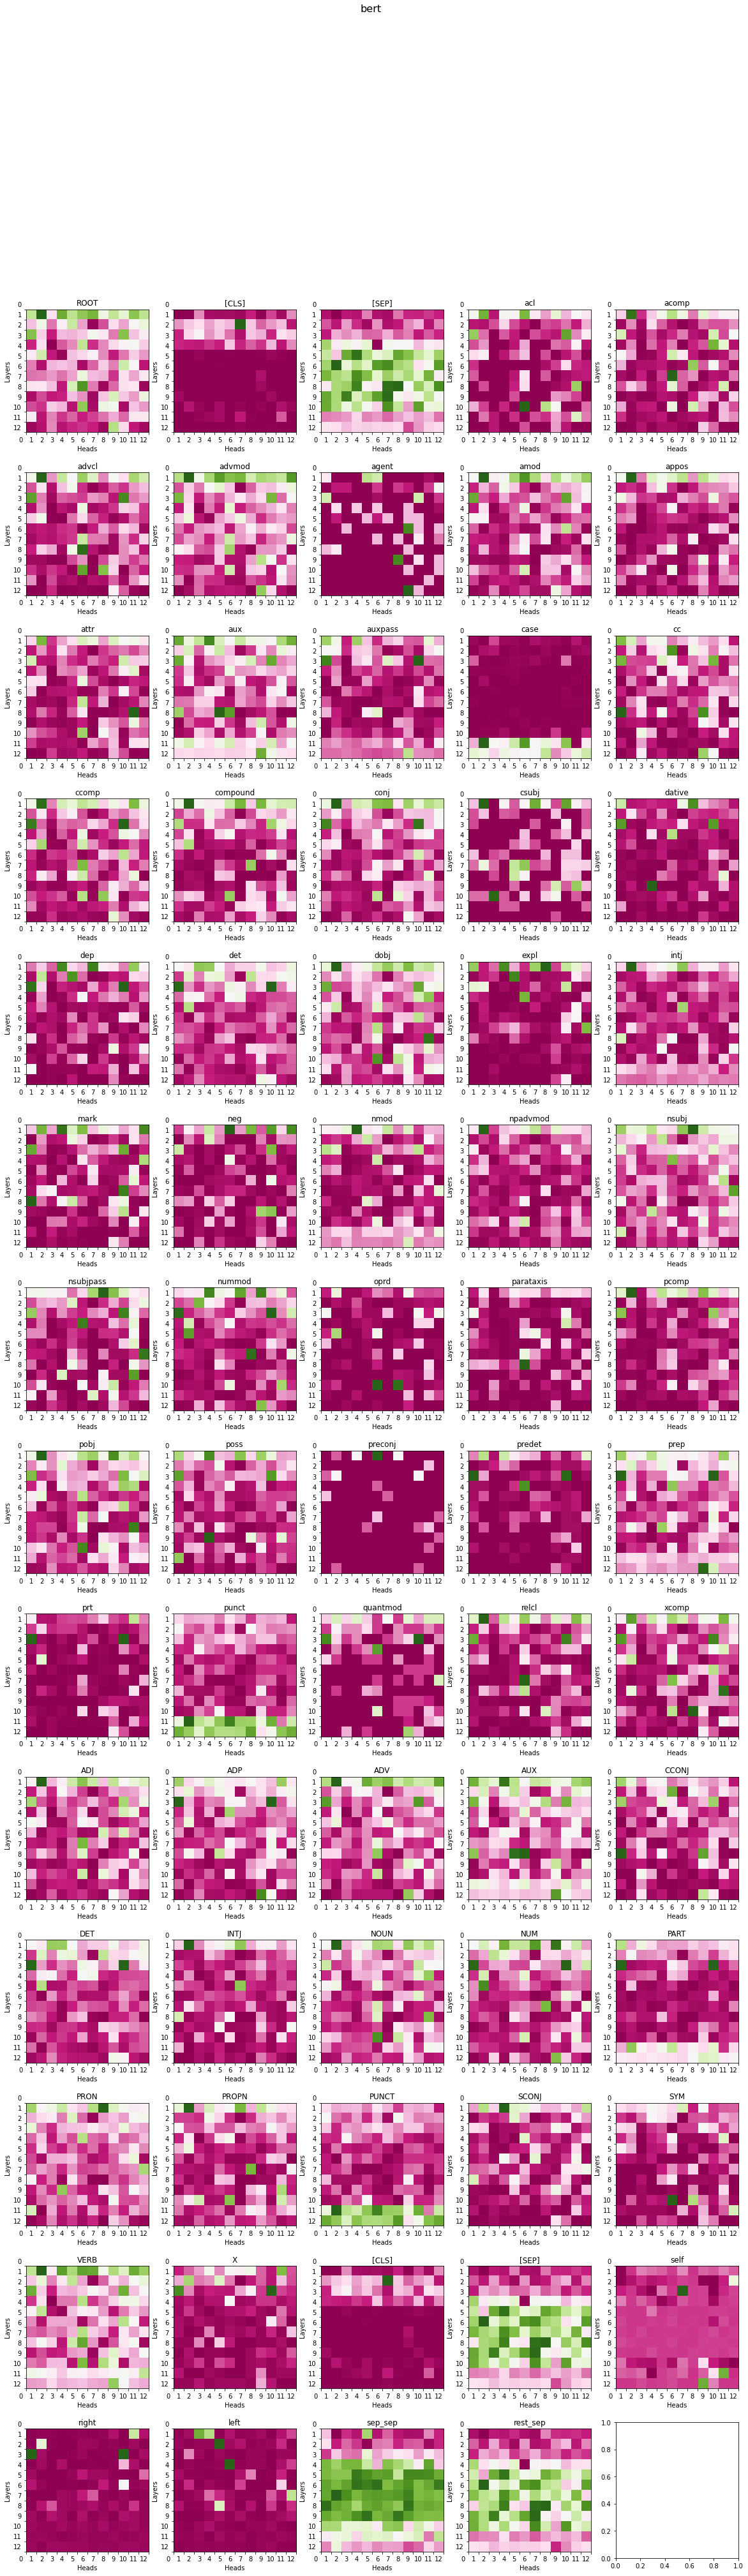

In [290]:
plot_avg_matrices(avg_attention_dicts[model], model)

#### Analysing average differences in attentions

In [295]:
def compute_difference(attn_dict1, attn_dict2):
    lst_dict_diff = []
    for d1, d2 in zip(data_iterator(attn_dict1), data_iterator(attn_dict2)):
        if (d1[0] == d2[0]):
            dict_diff = {}
            dict_diff['tokens'] = d1[0]
            dict_diff['attns'] = d1[1] - d2[1]
            dict_diff['relns'], dict_diff['words'], dict_diff['heads'], dict_diff['pos'], dict_diff['relns_aligned'], dict_diff['words_aligned'], dict_diff['heads_aligned'], dict_diff['pos_aligned'] = d1[2], d1[3], d1[4], d1[5], d1[6], d1[7], d1[8], d1[9]
            lst_dict_diff.append(dict_diff)
    return lst_dict_diff

In [296]:
diff_attns = {
    "-".join([c[0][0], c[1][0]]): compute_difference(attention_dicts[c[0][0]], attention_dicts[c[1][0]]) for c in combinations(keys,2)
}

0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done
0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done
0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done
0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done
0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done
0.3% done
0.3% done
33.7% done
33.7% done
67.0% done
67.0% done
100.0% done
100.0% done


In [297]:
avg_diff_attention_dicts = compute_avg_attn(diff_attns)

Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done
Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done
Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done


In [298]:
model = list(avg_diff_attention_dicts.keys())[1]
model

'bert-bleurt'

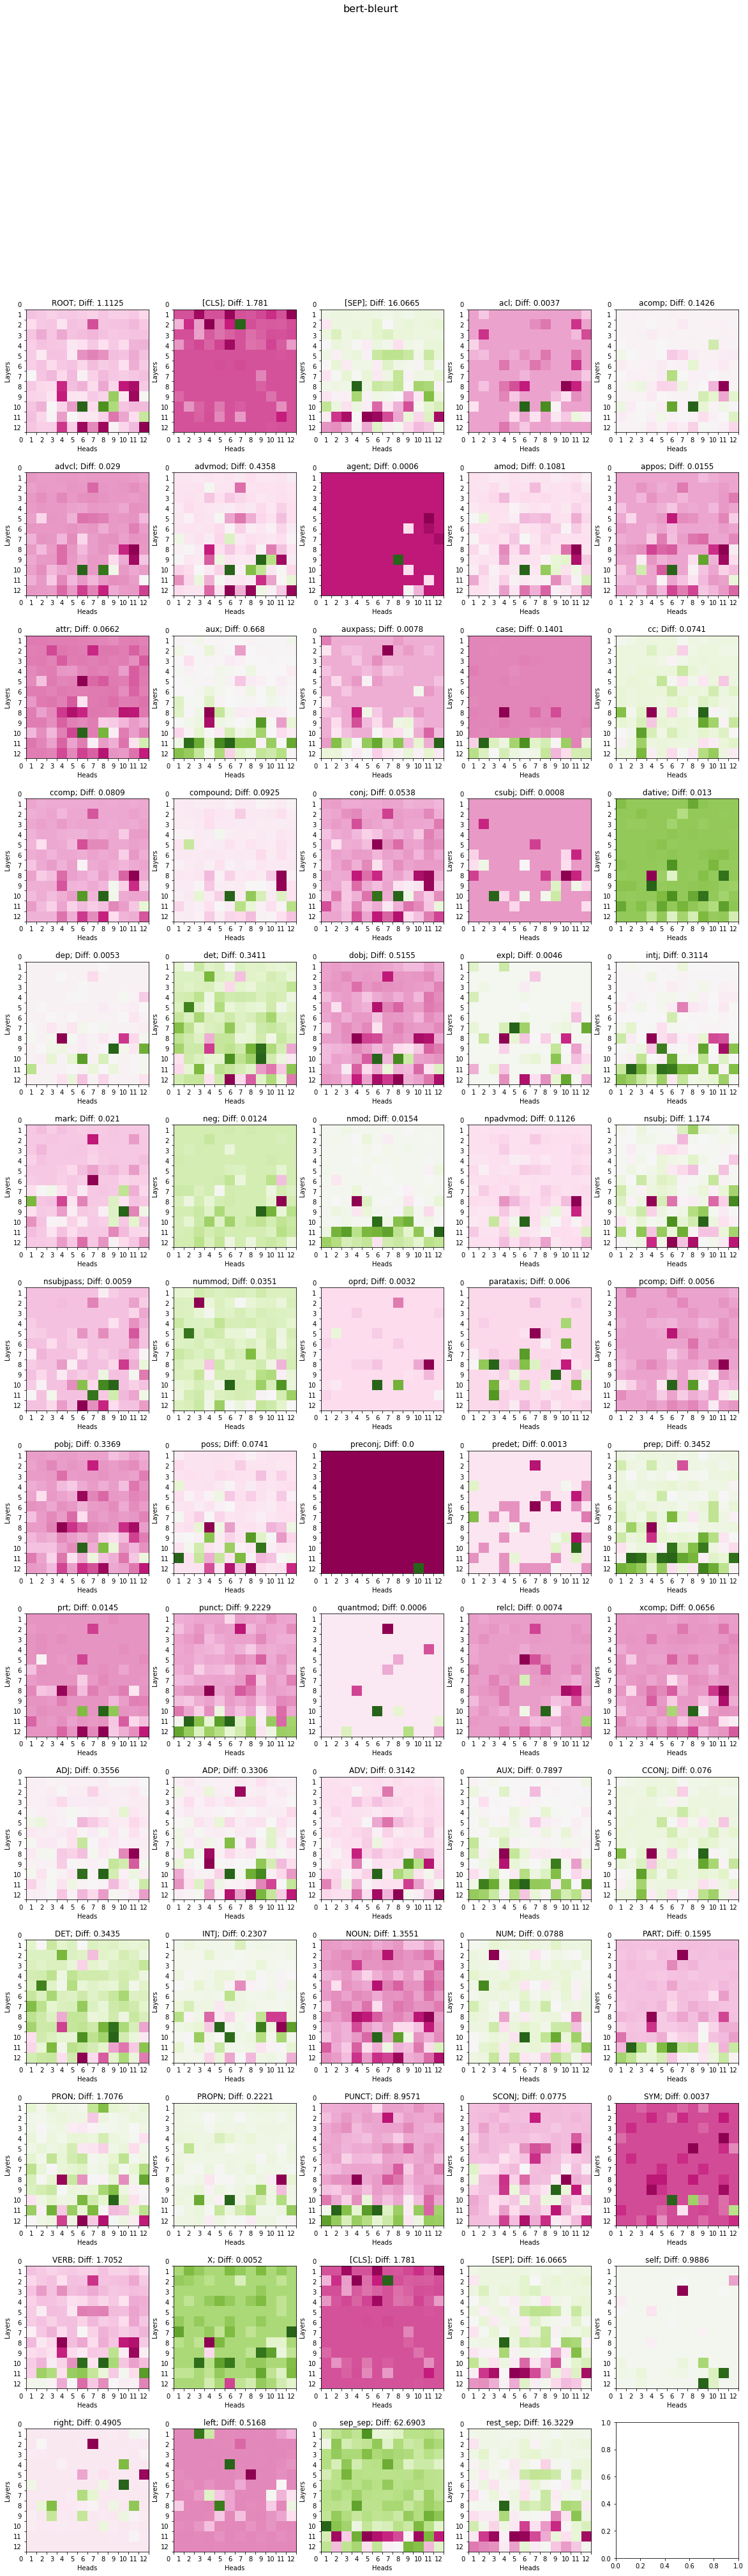

In [300]:
plot_avg_matrices(avg_diff_attention_dicts[model], model, True)